# Transfer Function
$$
T_a(\omega)=\left|\left|\frac{\widetilde{\Delta s}(\omega)}{\widetilde{\Delta i}(\omega)}\right|\right|
$$
where $\widetilde{\Delta s}(\omega)$ and $\widetilde{\Delta i}(\omega)$ are $\mathcal{F}[\Delta s]$ and $\mathcal{F}[\Delta i]$, the Fourier transforms of the perturbations of the input and spill signal

Ripples have the expression
$$
r(t)=A_K\cdot\sin(2\pi ft+\phi)
$$
where $A_K$ is the amplitude (in units of quad strength), $f$ is frequency (Hz), and $\phi$ is phase shift, assumed to be constant and equal to 0 without loss of generality

In [1]:
import jpype

jpype.startJVM(jpype.getDefaultJVMPath())

In [107]:
import pickle as pkl
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import rfft, rfftfreq
from scipy.signal import chirp as chirpsig
from scipy.signal import find_peaks as find_peaks

# Filled intervals, Gain Scan
## 1ms

18741.542878775952
18796.35651425328
18802.011063103313
18895.804753428645
18731.99387089161
18774.26573846697
18809.296306606575
18782.305565572784
18698.648835635136
18824.4507025285
Scope sample frequency: 199999.99999999997 Hz


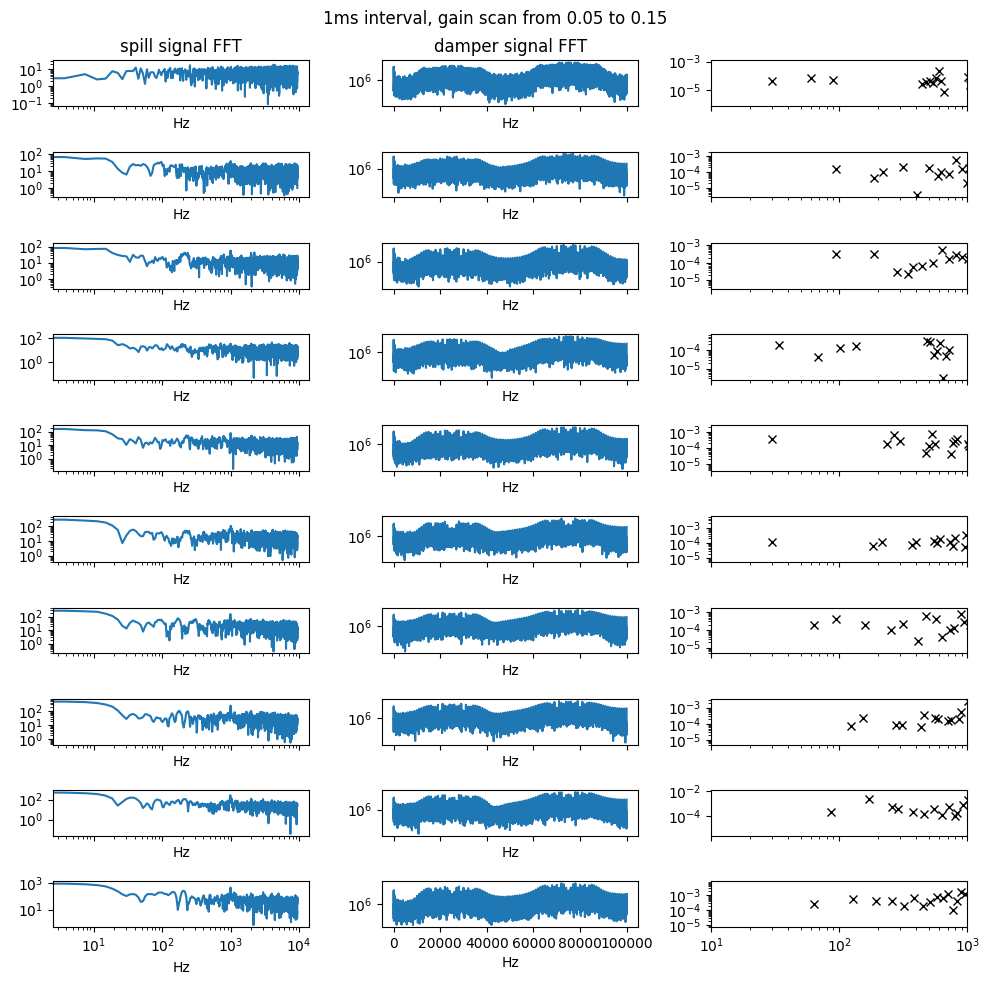

In [571]:
# Gain scan
dir = '../results/2022-11-23T11:04:28'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')][1:]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')][1:]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')][1:]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')][1:]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')][1:]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')][1:]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files]

# scope_time_per_sample = 0.05 / len(scope0[0]['data']['time'])
# scope_sample_rate = 1/scope_time_per_sample

# cal_time_per_sample = ((cal1100[0]['timeArray'] - cal1100[0]['timeArray'][0]) * 1e-6)[-1] / len(cal1100[0]['timeArray'])
# cal_sample_rate = 1/cal_time_per_sample

scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

fig, ax = plt.subplots(len(cal1000), 3, figsize=(10, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):

    cal_time_per_sample = ((cal['timeArray'] - cal['timeArray'][0]) * 1e-6)[-1] / len(cal['timeArray'])
    cal_sample_rate = 1/cal_time_per_sample

    rep_rate = param/1000
    cal_time = np.array(cal['timeArray']) * 1e-6 # convert to seconds
    cal_timeRebase = cal_time - cal_time[0]
    cal_data = np.array(cal['countArray'])
    cal_df = rfft(cal_data)
    cal_xf = rfftfreq(len(cal_data), cal_time_per_sample)
    ax[i, 0].plot(cal_xf, np.abs(cal_df))
    #ax[i, 0].set_xlim(0, 8000)
    ax[i, 0].set_xlabel("Hz")

    scp_time = np.array(scp['data']['time']) * 1e-9 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])
    scp_df = rfft(scp_data)
    scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)

    ax[i, 1].plot(scp_xf, np.abs(scp_df))
    #ax[i, 1].set_xlim(0, 8000)
    ax[i, 1].set_xlabel("Hz")

    for cal_indx, cal_hz in enumerate(np.round_(cal_xf, 1)):
        try:
            scp_indx = np.where(np.isclose(np.round_(scp_xf, 1), cal_hz))[0][0]
            scp_val = np.abs(scp_df[scp_indx])
            cal_val = np.abs(cal_df[cal_indx])
            ax[i, 2].plot(cal_hz, cal_val/scp_val, 'kx')
        except IndexError:
            pass
            
    ax[i, 0].set_xscale('log')
    #ax[i, 1].set_xscale('log')
    ax[i, 2].set_xscale('log')

    ax[i, 0].set_yscale('log')
    ax[i, 1].set_yscale('log')
    ax[i, 2].set_yscale('log')

    ax[i, 2].set_xlim(10, 10e2)

ax[0, 0].set_title('spill signal FFT')
ax[0, 1].set_title('damper signal FFT')
# ax[0, 2].set_title('spill FFT / damper FFT, transfer function')
plt.suptitle("1ms interval, gain scan from 0.05 to 0.15")

print(f"Scope sample frequency: {scope_sample_rate} Hz")

## 3ms

Text(0.5, 0.98, '3ms interval, gain scan from 0.05 to 0.15')

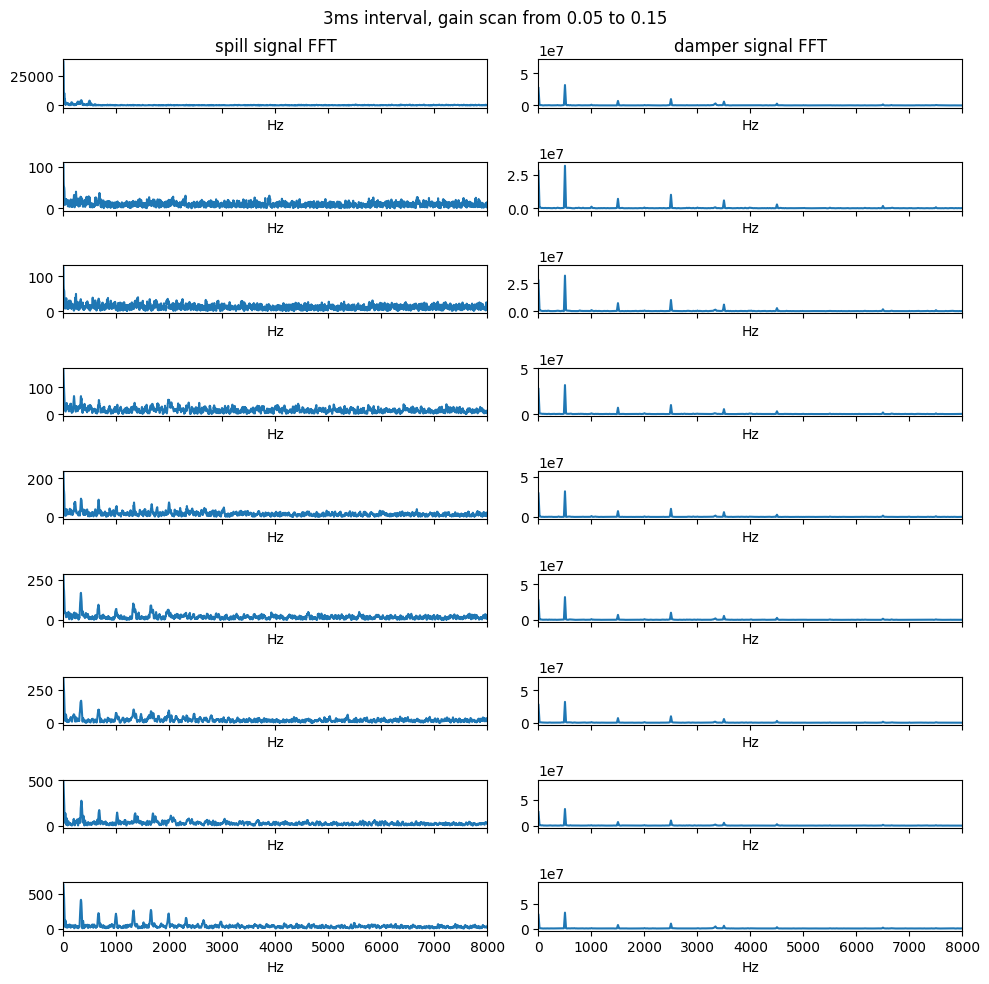

In [48]:
# Gain scan
dir = '../results/2022-11-23T10:53:27'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')][1:]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')][1:]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')][1:]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')][1:]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')][1:]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')][1:]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files]

scope_time_per_sample = 0.05 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

cal_time_per_sample = ((cal1100[0]['timeArray'] - cal1100[0]['timeArray'][0]) * 1e-6)[-1] / len(cal1100[0]['timeArray'])
cal_sample_rate = 1/cal_time_per_sample

fig, ax = plt.subplots(len(cal1000), 2, figsize=(10, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):
    rep_rate = param/1000
    cal_time = np.array(cal['timeArray']) * 1e-6 # convert to seconds
    cal_timeRebase = cal_time - cal_time[0]
    cal_data = np.array(cal['countArray'])
    cal_df = rfft(cal_data)
    cal_xf = rfftfreq(len(cal_data), cal_time_per_sample)
    ax[i, 0].plot(cal_xf, np.abs(cal_df))
    ax[i, 0].set_xlim(0, 8000)
    ax[i, 0].set_xlabel("Hz")

    scp_time = np.array(scp['data']['time']) * 1e-10 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])
    scp_df = rfft(scp_data)
    scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)

    ax[i, 1].plot(scp_xf, np.abs(scp_df))
    ax[i, 1].set_xlim(0, 8000)
    ax[i, 1].set_xlabel("Hz")

ax[0, 0].set_title('spill signal FFT')
ax[0, 1].set_title('damper signal FFT')
# ax[0, 2].set_title('spill FFT / damper FFT, transfer function')
plt.suptitle("3ms interval, gain scan from 0.05 to 0.15")

## 6ms

Text(0.5, 0.98, 'Gain scan from 0.05 to 0.15')

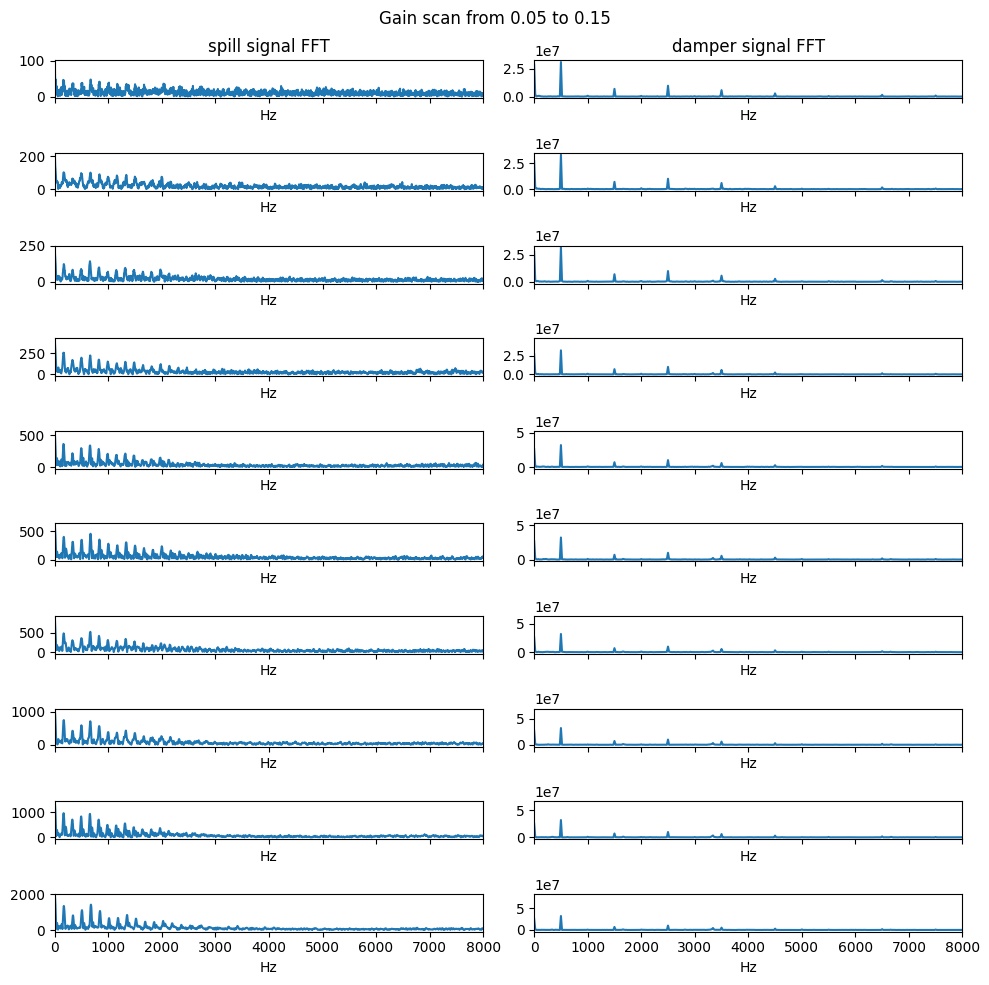

In [49]:
# Gain scan
dir = '../results/2022-11-23T10:36:24'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')][1:]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')][1:]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')][1:]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')][1:]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')][1:]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')][1:]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files]

scope_time_per_sample = 0.05 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

cal_time_per_sample = ((cal1100[0]['timeArray'] - cal1100[0]['timeArray'][0]) * 1e-6)[-1] / len(cal1100[0]['timeArray'])
cal_sample_rate = 1/cal_time_per_sample

fig, ax = plt.subplots(len(cal1000), 2, figsize=(10, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):
    rep_rate = param/1000
    cal_time = np.array(cal['timeArray']) * 1e-6 # convert to seconds
    cal_timeRebase = cal_time - cal_time[0]
    cal_data = np.array(cal['countArray'])
    cal_df = rfft(cal_data)
    cal_xf = rfftfreq(len(cal_data), cal_time_per_sample)
    ax[i, 0].plot(cal_xf, np.abs(cal_df))
    ax[i, 0].set_xlim(0, 8000)
    ax[i, 0].set_xlabel("Hz")

    scp_time = np.array(scp['data']['time']) * 1e-10 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])
    scp_df = rfft(scp_data)
    scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)

    ax[i, 1].plot(scp_xf, np.abs(scp_df))
    ax[i, 1].set_xlim(0, 8000)
    ax[i, 1].set_xlabel("Hz")

    # for freq in [1000]:
    #     indx = np.where(np.isclose(cal_xf, freq, atol=1))[0][0] - 1
    #     ax[i, 0].plot(cal_xf[indx], np.abs(cal_df[indx]), 'xr')

ax[0, 0].set_title('spill signal FFT')
ax[0, 1].set_title('damper signal FFT')
# ax[0, 2].set_title('spill FFT / damper FFT, transfer function')
plt.suptitle("Gain scan from 0.05 to 0.15")

# Interval Scan

Scope sample frequency: 250000.0 Hz


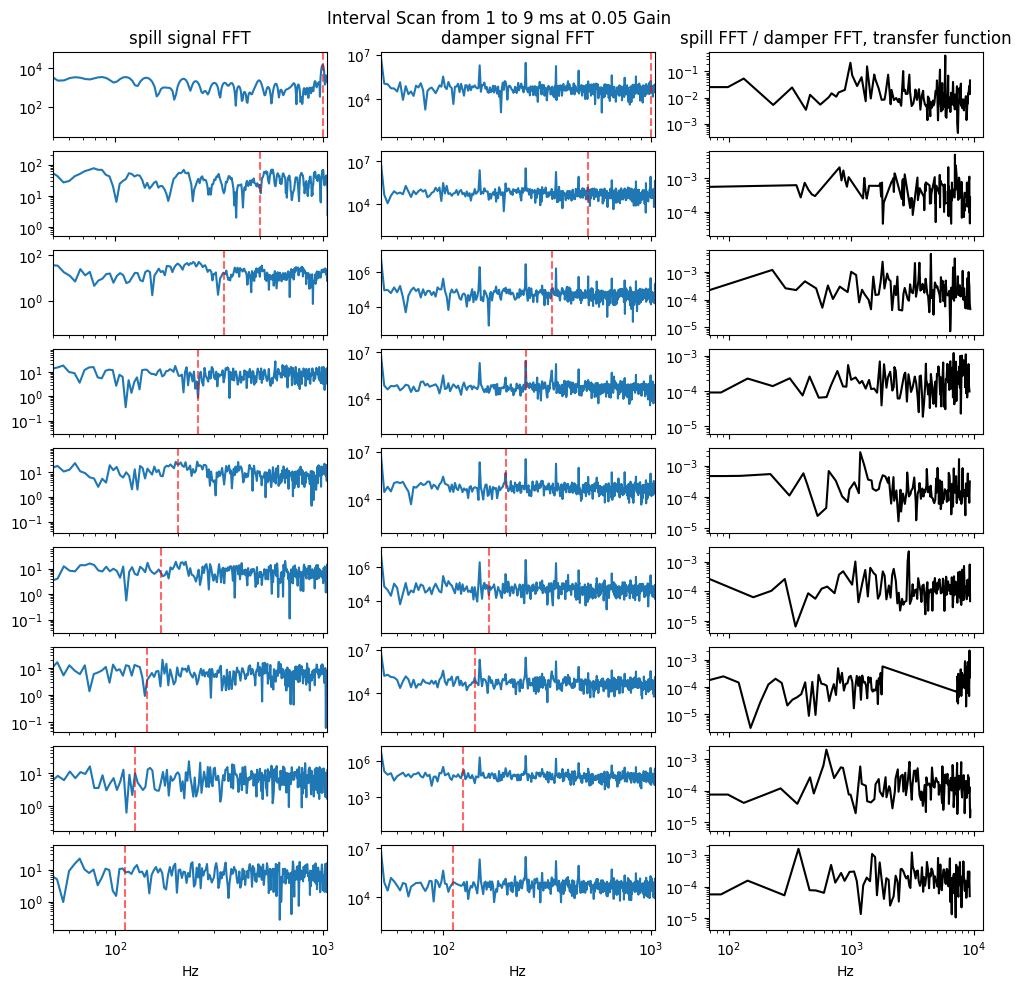

In [585]:
# Gain scan
dir = '../results/2022-11-23T14:34:55'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')][1:]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')][1:]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')][1:]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')][1:]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')][1:]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')][1:]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files]

# scope_time_per_sample = 0.05 / len(scope0[0]['data']['time'])
# scope_sample_rate = 1/scope_time_per_sample

# cal_time_per_sample = ((cal1100[0]['timeArray'] - cal1100[0]['timeArray'][0]) * 1e-6)[-1] / len(cal1100[0]['timeArray'])
# cal_sample_rate = 1/cal_time_per_sample

scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

fig, ax = plt.subplots(len(cal1000), 3, figsize=(10, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):

    cal_time_per_sample = ((cal['timeArray'] - cal['timeArray'][0]) * 1e-6)[-1] / len(cal['timeArray'])
    cal_sample_rate = 1/cal_time_per_sample

    rep_rate = 1 / (param*1e-3)
    cal_time = np.array(cal['timeArray']) * 1e-6 # convert to seconds
    cal_timeRebase = cal_time - cal_time[0]
    cal_data = np.array(cal['countArray'])
    cal_df = rfft(cal_data)
    cal_xf = rfftfreq(len(cal_data), cal_time_per_sample)
    ax[i, 0].plot(cal_xf, np.abs(cal_df))
    #ax[i, 0].set_xlim(0, 8000)
    #ax[i, 0].set_xlabel("Hz")

    scp_time = np.array(scp['data']['time']) * 1e-9 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])
    scp_df = rfft(scp_data)
    scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)

    ax[i, 1].plot(scp_xf, np.abs(scp_df))
    #ax[i, 1].set_xlabel("Hz")


    hz_dat = []
    tf_dat = []
    for cal_indx, cal_hz in enumerate(np.round_(cal_xf, 1)):
        try:
            scp_indx = np.where(np.isclose(np.round_(scp_xf, 1), cal_hz))[0][0]
            scp_val = np.abs(scp_df[scp_indx])
            cal_val = np.abs(cal_df[cal_indx])
            hz_dat.append(cal_hz)
            tf_dat.append(cal_val/scp_val)
        except IndexError:
            pass

    ax[i, 2].plot(hz_dat, tf_dat, 'k-')
            
    ax[i, 0].set_xscale('log')
    ax[i, 1].set_xscale('log')
    ax[i, 2].set_xscale('log')

    ax[i, 0].set_yscale('log')
    ax[i, 1].set_yscale('log')
    ax[i, 2].set_yscale('log')

    ax[i, 0].set_xlim(50, 1050)
    ax[i, 1].set_xlim(50, 1050)

    ax[i, 0].axvline(rep_rate, 0, 1, color='r', linestyle='--', alpha=0.6)
    ax[i, 1].axvline(rep_rate, 0, 1, color='r', linestyle='--', alpha=0.6)

ax[0, 0].set_title('spill signal FFT')
ax[0, 1].set_title('damper signal FFT')
ax[0, 2].set_title('spill FFT / damper FFT, transfer function')

ax[i, 0].set_xlabel("Hz")
ax[i, 1].set_xlabel("Hz")
ax[i, 2].set_xlabel("Hz")
plt.suptitle("Interval Scan from 1 to 9 ms at 0.05 Gain")

print(f"Scope sample frequency: {scope_sample_rate} Hz")
plt.tight_layout(pad=0.8, w_pad=0.1, h_pad=0.4)

Scope sample frequency: 250000.0 Hz


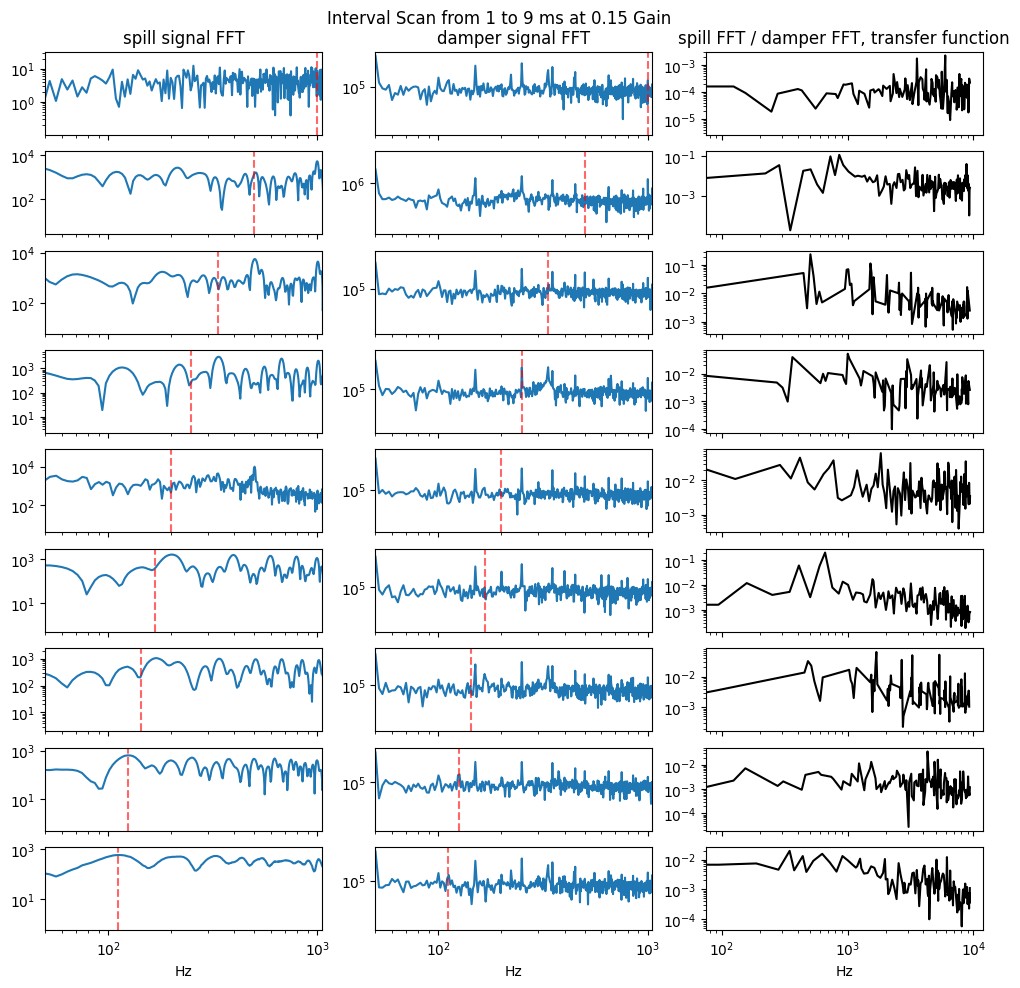

In [565]:
# Gain scan
dir = '../results/2022-11-23T15:16:55'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')][1:]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')][1:]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')][1:]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')][1:]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')][1:]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')][1:]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files]

# scope_time_per_sample = 0.05 / len(scope0[0]['data']['time'])
# scope_sample_rate = 1/scope_time_per_sample

# cal_time_per_sample = ((cal1100[0]['timeArray'] - cal1100[0]['timeArray'][0]) * 1e-6)[-1] / len(cal1100[0]['timeArray'])
# cal_sample_rate = 1/cal_time_per_sample

scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

fig, ax = plt.subplots(len(cal1000), 3, figsize=(10, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):

    cal_time_per_sample = ((cal['timeArray'] - cal['timeArray'][0]) * 1e-6)[-1] / len(cal['timeArray'])
    cal_sample_rate = 1/cal_time_per_sample

    rep_rate = 1 / (param*1e-3)
    cal_time = np.array(cal['timeArray']) * 1e-6 # convert to seconds
    cal_timeRebase = cal_time - cal_time[0]
    cal_data = np.array(cal['countArray'])
    cal_df = rfft(cal_data)
    cal_xf = rfftfreq(len(cal_data), cal_time_per_sample)
    ax[i, 0].plot(cal_xf, np.abs(cal_df))
    #ax[i, 0].set_xlim(0, 8000)
    #ax[i, 0].set_xlabel("Hz")

    scp_time = np.array(scp['data']['time']) * 1e-9 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])
    scp_df = rfft(scp_data)
    scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)

    ax[i, 1].plot(scp_xf, np.abs(scp_df))
    #ax[i, 1].set_xlabel("Hz")


    hz_dat = []
    tf_dat = []
    for cal_indx, cal_hz in enumerate(np.round_(cal_xf, 1)):
        try:
            scp_indx = np.where(np.isclose(np.round_(scp_xf, 1), cal_hz))[0][0]
            scp_val = np.abs(scp_df[scp_indx])
            cal_val = np.abs(cal_df[cal_indx])
            hz_dat.append(cal_hz)
            tf_dat.append(cal_val/scp_val)
        except IndexError:
            pass

    ax[i, 2].plot(hz_dat, tf_dat, 'k-')
            
    ax[i, 0].set_xscale('log')
    ax[i, 1].set_xscale('log')
    ax[i, 2].set_xscale('log')

    ax[i, 0].set_yscale('log')
    ax[i, 1].set_yscale('log')
    ax[i, 2].set_yscale('log')

    ax[i, 0].set_xlim(50, 1050)
    ax[i, 1].set_xlim(50, 1050)

    ax[i, 0].axvline(rep_rate, 0, 1, color='r', linestyle='--', alpha=0.6)
    ax[i, 1].axvline(rep_rate, 0, 1, color='r', linestyle='--', alpha=0.6)

ax[0, 0].set_title('spill signal FFT')
ax[0, 1].set_title('damper signal FFT')
ax[0, 2].set_title('spill FFT / damper FFT, transfer function')

ax[i, 0].set_xlabel("Hz")
ax[i, 1].set_xlabel("Hz")
ax[i, 2].set_xlabel("Hz")
plt.suptitle("Interval Scan from 1 to 9 ms at 0.15 Gain")

print(f"Scope sample frequency: {scope_sample_rate} Hz")
plt.tight_layout(pad=0.8, w_pad=0.1, h_pad=0.4)

## 50Hz

Scope sample frequency: 199999.99999999997 Hz


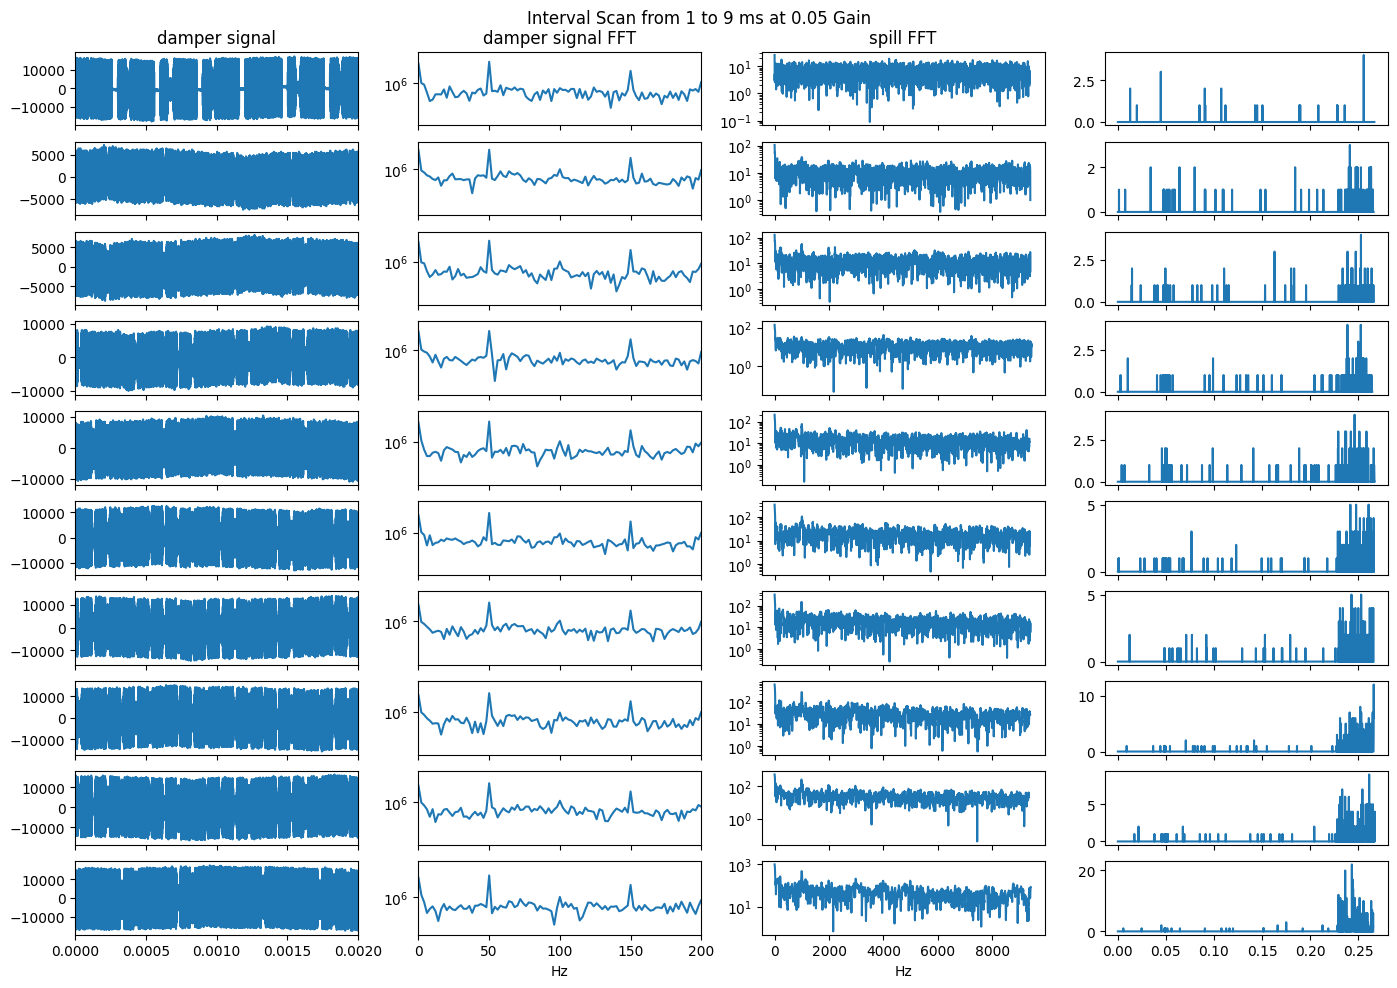

In [584]:
# Gain scan
dir = '../results/2022-11-23T11:04:28'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')][1:]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')][1:]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')][1:]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')][1:]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')][1:]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')][1:]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files]

scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

fig, ax = plt.subplots(len(cal1000), 4, figsize=(14, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):

    cal_time_per_sample = ((cal['timeArray'] - cal['timeArray'][0]) * 1e-6)[-1] / len(cal['timeArray'])
    cal_sample_rate = 1/cal_time_per_sample

    rep_rate = 1 / (param*1e-3)
    cal_time = np.array(cal['timeArray']) * 1e-6 # convert to seconds
    cal_timeRebase = cal_time - cal_time[0]
    cal_data = np.array(cal['countArray'])
    cal_df = rfft(cal_data)
    cal_xf = rfftfreq(len(cal_data), cal_time_per_sample)
    ax[i, 2].plot(cal_xf, np.abs(cal_df))
    ax[i, 3].plot(cal_timeRebase, cal_data)

    scp_time = np.array(scp['data']['time']) * 1e-9 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])
    scp_df = rfft(scp_data)
    scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)

    ax[i, 0].plot(scp_timeRebase, scp_data)
    ax[i, 1].plot(scp_xf, np.abs(scp_df))
    #ax[i, 1].set_xlabel("Hz")

            

    ax[i, 1].set_yscale('log')
    ax[i, 2].set_yscale('log')

    ax[i, 0].set_xlim(0, 0.002)
    ax[i, 1].set_xlim(0, 200)

    ax[i, 1].axvline(rep_rate, 0, 1, color='r', linestyle='--', alpha=0.6)

ax[0, 0].set_title('damper signal')
ax[0, 1].set_title('damper signal FFT')
ax[0, 2].set_title('spill FFT')

ax[i, 1].set_xlabel("Hz")
ax[i, 2].set_xlabel("Hz")
plt.suptitle("Interval Scan from 1 to 9 ms at 0.05 Gain")

print(f"Scope sample frequency: {scope_sample_rate} Hz")
plt.tight_layout(pad=0.8, w_pad=0.1, h_pad=0.4)

[1 2 3 4 5 6 7 8 9]


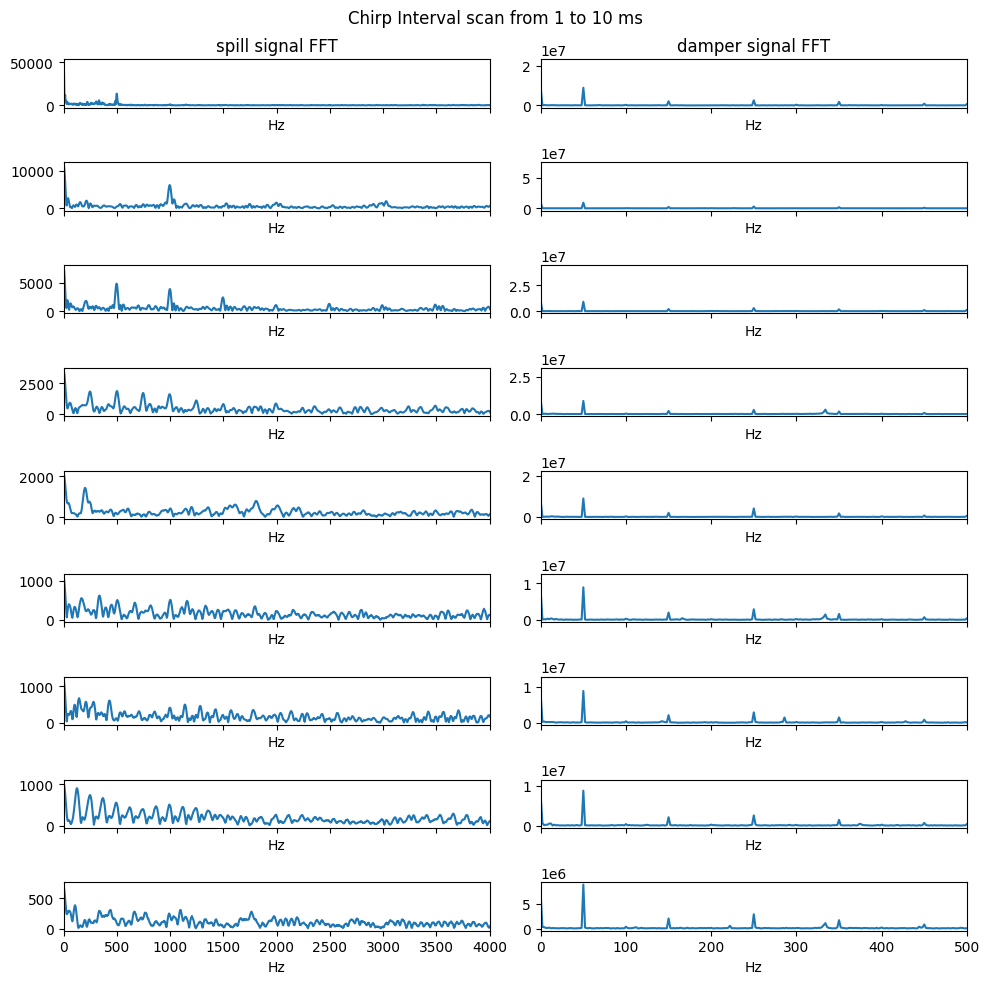

In [367]:
# Gain scan
dir = '../results/2022-11-23T15:08:29'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')][1:]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')][1:]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')][1:]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')][1:]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')][1:]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')][1:]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files]

scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

cal_time_per_sample = ((cal1100[0]['timeArray'] - cal1100[0]['timeArray'][0]) * 1e-6)[-1] / len(cal1100[0]['timeArray'])
cal_sample_rate = 1/cal_time_per_sample

fig, ax = plt.subplots(len(cal1000), 2, figsize=(10, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):
    rep_rate = param/1000
    cal_time = np.array(cal['timeArray']) * 1e-6 # convert to seconds
    cal_timeRebase = cal_time - cal_time[0]
    cal_data = np.array(cal['countArray'])
    cal_df = rfft(cal_data)
    cal_xf = rfftfreq(len(cal_data), cal_time_per_sample)
    ax[i, 0].plot(cal_xf, np.abs(cal_df))
    ax[i, 0].set_xlim(0, 4000)
    ax[i, 0].set_xlabel("Hz")

    scp_time = np.array(scp['data']['time']) * 1e-10 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])
    scp_df = rfft(scp_data)
    scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)

    ax[i, 1].plot(scp_xf, np.abs(scp_df))
    ax[i, 1].set_xlim(0, 500)
    ax[i, 1].set_xlabel("Hz")

    # for freq in [1000]:
    #     indx = np.where(np.isclose(cal_xf, freq, atol=1))[0][0] - 1
    #     ax[i, 0].plot(cal_xf[indx], np.abs(cal_df[indx]), 'xr')

ax[0, 0].set_title('spill signal FFT')
ax[0, 1].set_title('damper signal FFT')
# ax[0, 2].set_title('spill FFT / damper FFT, transfer function')
plt.suptitle("Chirp Interval scan from 1 to 10 ms")
print(initial['param_space'])

ValueError: x and y must have same first dimension, but have shapes (62501,) and (2501,)

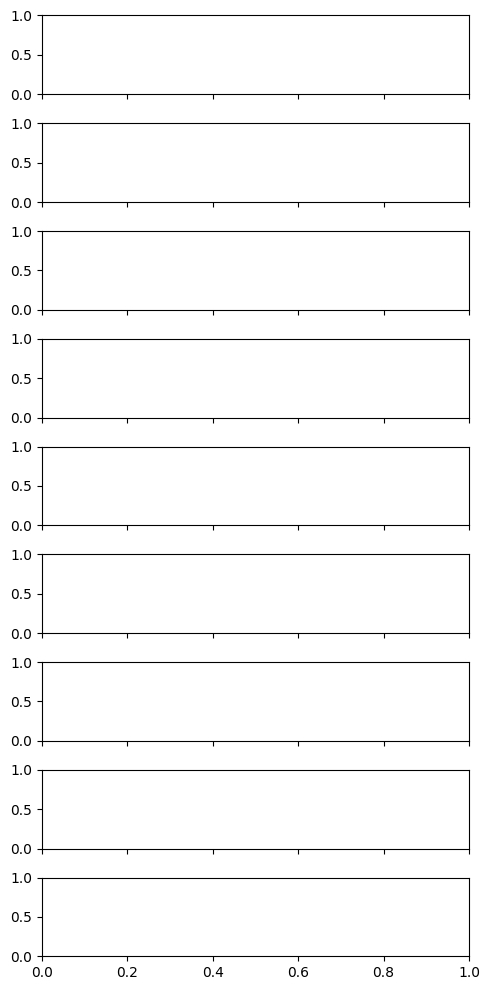

In [370]:
fig, ax = plt.subplots(len(cal1000), 1, figsize=(5, 10), sharex='col', tight_layout=True)

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'], cal1100, scope0))):
    rep_rate = param/1000
    cal_time = np.array(cal['timeArray']) * 1e-6 # convert to seconds
    cal_timeRebase = cal_time - cal_time[0]
    cal_data = np.array(cal['countArray'])
    cal_df = rfft(cal_data)
    cal_xf = rfftfreq(len(cal_data), cal_time_per_sample)
    

    scp_time = np.array(scp['data']['time']) * 1e-10 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])
    scp_df = rfft(scp_data)
    scp_xf = rfftfreq(len(scp_data), scope_time_per_sample)

    ax[i].plot(np.abs(scp_df), np.abs(cal_df))


    # for freq in [1000]:
    #     indx = np.where(np.isclose(cal_xf, freq, atol=1))[0][0] - 1
    #     ax[i, 0].plot(cal_xf[indx], np.abs(cal_df[indx]), 'xr')

ax[0, 0].set_title('spill signal FFT')
ax[0, 1].set_title('damper signal FFT')
# ax[0, 2].set_title('spill FFT / damper FFT, transfer function')
plt.suptitle("Chirp Interval scan from 1 to 10 ms")
print(initial['param_space'])

# Figuring out timebases

In [ ]:
# 50ms / div
dir = '../results/2022-11-17T12:27:29.119159'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]

print(f"{len(scope0[0]['data']['time'])} points in 50ms = 4e-7 s per point")

125000 points in 50ms = 4e-7 s per point


In [ ]:
# 50ms / div
dir = '../results/2022-11-17T13:27:16.876335'

files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]

print(f"{len(scope0[0]['data']['time'])} points in 80ms = 1e-6 s per point")

80000 points in 80ms = 1e-6 s per point


# Single Chirps to find frequencies
Using `2022-11-22T11:28:50`

In [77]:
dir = '../results/2022-11-22T11:28:50'
files = os.listdir(dir)

scope0_files = [f for f in files if f.startswith('scope_0') and f.endswith('.pkl')][1:]
scope1_files = [f for f in files if f.startswith('scope_1') and f.endswith('.pkl')][1:]
cal1000_files = [f for f in files if f.startswith('BXSCAL_1000_signal') and f.endswith('.pkl')][1:]
cal1100_files = [f for f in files if f.startswith('BXSCAL_1100_signal') and f.endswith('.pkl')][1:]
int1000_files = [f for f in files if f.startswith('BXSCINT_1000') and f.endswith('.pkl')][1:]
int1001_files = [f for f in files if f.startswith('BXSCINT_1001') and f.endswith('.pkl')][1:]
qmeter_files = [f for f in files if f.startswith('qmeter_') and f.endswith('.pkl')][1:]
blm_files = [f for f in files if f.startswith('blm_') and f.endswith('.pkl')][1:]

scope0_files.sort(key=lambda x: x.split('T')[1])
scope1_files.sort(key=lambda x: x.split('T')[1])
cal1000_files.sort(key=lambda x: x.split('T')[1])
cal1100_files.sort(key=lambda x: x.split('T')[1])
int1000_files.sort(key=lambda x: x.split('T')[1])
int1001_files.sort(key=lambda x: x.split('T')[1])
qmeter_files.sort(key=lambda x: x.split('T')[1])
blm_files.sort(key=lambda x: x.split('T')[1])

initial = pkl.load(open(f"{dir}/initial.pkl", 'rb'))

scope0 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope0_files]
scope1 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in scope1_files]
cal1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1000_files]
cal1100 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in cal1100_files]
int1000 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1000_files]
int1001 = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in int1001_files]
qmeter = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in qmeter_files]
blm = [pkl.load(open(f"{dir}/{f}", 'rb')) for f in blm_files]

scope_time_per_sample = scope0[0]['data']['time'][-1] * 1e-09 / len(scope0[0]['data']['time'])
scope_sample_rate = 1/scope_time_per_sample

cal_time_per_sample = ((cal1100[0]['timeArray'] - cal1100[0]['timeArray'][0]) * 1e-6)[-1] / len(cal1100[0]['timeArray'])
cal_sample_rate = 1/cal_time_per_sample


- 80us/div horizontal, 62.5V/div vertical
- so the scope should show 800us of data

In [82]:
print(f"{scope_time_per_sample * len(scope0[0]['data']['time'])}s of data")

0.0008s of data


In [104]:
fig, ax = plt.subplots(len(cal1000[1:]), 2, figsize=(10, 10), sharex='col')

#fig.suptitle('cal1100', y=0.1)
for i, (param, cal, scp) in enumerate(list(zip(initial['param_space'][1:], cal1100[1:], scope0[1:]))):
    rep_rate = param/1000

    scp_time = np.array(scp['data']['time']) * 1e-9 # convert to seconds
    scp_timeRebase = scp_time - scp_time[0]
    scp_data = np.array(scp['data']['value'])

    ax[i, 0].plot(scp_timeRebase[600:65500], scp_data[600:65500])

    scp_df = rfft(scp_data[600:65500])
    scp_xf = rfftfreq(len(scp_data[600:65500]), scope_time_per_sample)

    ax[i, 1].plot(scp_xf, np.abs(scp_df))
    ax[i, 1].set_xlim(600, 1000)
    ax[i, 1].set_xlabel("Hz")

    

    # for freq in [1000]:
    #     indx = np.where(np.isclose(cal_xf, freq, atol=1))[0][0] - 1
    #     ax[i, 0].plot(cal_xf[indx], np.abs(cal_df[indx]), 'xr')

ax[0, 0].set_title('spill signal FFT')
ax[0, 1].set_title('damper signal FFT')
# ax[0, 2].set_title('spill FFT / damper FFT, transfer function')
plt.suptitle("Chirp Interval scan from 1 to 10 ms")
print(initial['param_space'])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [194]:
from scipy.signal import get_window

fig, ax = plt.subplots(1, 2, figsize=(10, 2), sharex='col')

#fig.suptitle('cal1100', y=0.1)
timearr = np.linspace(0, 6.5e-6, 100000)
amparr = chirpsig(timearr, 100000*397*0.3, timearr[-1], 100000*397*0.35)

scope_time_per_sample = timearr[-1] / len(timearr)
scope_sample_rate = 1/scope_time_per_sample

w = get_window(('tukey', 0.001), len(amparr))

scp_df = rfft(amparr*w)
scp_xf = rfftfreq(len(timearr), scope_time_per_sample)

ax[0].plot(timearr, amparr*w)

ax[1].plot(scp_xf, np.abs(scp_df))
ax[1].set_xlim(0.1e8, 0.2e8)

# ax[0, 2].set_title('spill FFT / damper FFT, transfer function')
plt.suptitle("Chirp Interval scan from 1 to 10 ms")
print(initial['param_space'])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


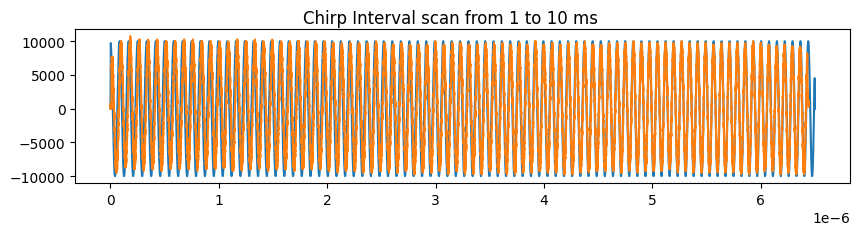

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2), sharex='col')

#fig.suptitle('cal1100', y=0.1)
timearr = np.linspace(0, 6.5e-6, 100000)
amparr = chirpsig(timearr, 3.97e7*0.3, timearr[-1], 3.97e7*0.35)

scope_time_per_sample = timearr[-1] / len(timearr)
scope_sample_rate = 1/scope_time_per_sample

w = get_window(('tukey', 0.001), len(amparr))

ax.plot(timearr, amparr*w*10000)

scp_time = np.array(scope0[1]['data']['time']) * 1e-11 # convert to seconds
scp_timeRebase = scp_time - scp_time[0]
scp_data = np.array(scope0[1]['data']['value'])

ax.plot(scp_timeRebase[1100:65500]-scp_timeRebase[1100], scp_data[1100:65500])
plt.suptitle("Chirp Interval scan from 1 to 10 ms")
print(initial['param_space'])

In [328]:
3.97e7*0.3 * 1e-7

1.1909999999999998

In [557]:
fig, ax = plt.subplots(2, 1, figsize=(10, 3))

#fig.suptitle('cal1100', y=0.1)
timearr = np.linspace(0, 6.5e-6, 100000)
amparr = chirpsig(timearr, 3.97e7*0.3, timearr[-1], 3.97e7*0.35, phi=120)

scope_time_per_sample = timearr[-1] / len(timearr)
scope_sample_rate = 1/scope_time_per_sample

w = get_window(('tukey', 0.001), len(amparr))

reps = 2
sigResize = np.tile(amparr*w*10000, reps)
timeResize = np.linspace(0, 6.5e-6 * reps, 100000 * reps)

scp_df = rfft(sigResize)
scp_xf = rfftfreq(len(sigResize), scope_time_per_sample)

scp_df1 = rfft(amparr)
scp_xf1 = rfftfreq(len(amparr), scope_time_per_sample)

sigResize397 = np.tile(amparr*w*10000, 397)
timeResize397 = np.linspace(0, 6.5e-6 * 397, 100000 * 397)

scp_df2 = rfft(sigResize397)
scp_xf2 = rfftfreq(len(sigResize397), scope_time_per_sample)

ax[0].plot(timeResize, sigResize)

ax[1].plot(scp_xf, np.abs(scp_df))

ax[1].plot(scp_xf1, np.abs(scp_df1)*20000)

ax[1].plot(scp_xf2, np.abs(scp_df2)/200)
ax[1].set_xlim(1e7, 1.75e7)

ax[1].vlines(3.97e7*0.3, ymin=0, ymax=4e8, color='k', linestyles=':')
ax[1].vlines(3.97e7*0.35, ymin=0, ymax=4e8, color='k', linestyles=':')

print(initial['param_space'])

[1 2 3 4 5 6 7 8 9]


In [452]:
a = np.array([5, 4, 1.000001])
np.where(np.isclose(a, 1, atol=1e-6))

(array([2]),)

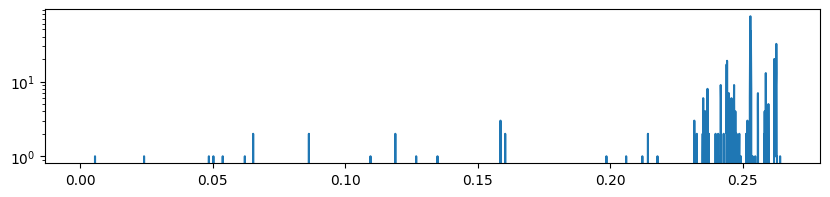

In [567]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2), sharex='col')
ax.plot(cal_timeRebase, cal_data)
ax.set_yscale('log')

In [568]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2), sharex='col')
ax.plot(cal_xf, np.abs(cal_df))
ax.set_yscale('log')

In [570]:
blm

[{'superCycleDuration': 47,
  'firstSampleTime': 100.0,
  'cycleTimeStamp': 1669212972700000000,
  'hotSpotsTimes': array([  67.,  224.,  244.,    0.,    0.,    0.,    0., 1099., 1119.,
         1961., 1981.]),
  'firstSampleTime_units': 'ms',
  'hotSpotsSamples_units': 'E10',
  'samples_units': 'E10',
  'hotSpotsNames': array(['Blr', 'befInj1', 'aftInj1', 'befInj2', 'aftInj2', 'befTran.',
         'aftTran.', 'bejEj1', 'aftEj1', 'bejEj2', 'aftEj2'], dtype='<U8'),
  'beamDestinationName': 'EAST_DMP',
  'particleName': 'NOBEAM',
  'samplingTrain_units': 'ms',
  'samplingTrain': 1.0,
  'timeUnitFactor': 0.001,
  'basicPeriodMilliSecond': 1200,
  'samples': array([-0.49863511, -0.48500782, -0.46456689, ..., -0.08548031,
         -0.09229396, -0.08795799]),
  'hotSpotsTimes_units': 'ms',
  'hotSpotsSamples': array([        nan,  0.06256167,  2.7960732 ,         nan,         nan,
                 nan,         nan,  3.52637219,  3.51955843, -0.12822045,
         -0.11892913]),
  'samplingSta